<a href="https://colab.research.google.com/github/ZitongZhou/react_inverse/blob/master/CAAE_DenseED_ESMDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install attrdict
# !pip install --upgrade matplotlib

In [ ]:
%%capture
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [4]:
from tqdm import tqdm
import numpy as np
import scipy.linalg
import pickle as pkl
import time
import sys
import os
import copy
import torch
import scipy.io
from attrdict import AttrDict
import argparse
from google.colab import drive
from google.colab import files
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torch.distributions import Gamma
from torchsummary import summary
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors
from scipy import array, linalg, dot
import math
from scipy.io import savemat, loadmat
# import matplotlib.backends.backend_pdf
drive.mount('/content/drive', force_remount=True)
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rcParams['text.usetex'] = True
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

Mounted at /content/drive


# DenseED, Bayesian DenseED, and CAAE

In [16]:
"""
Convolutional Dense Encoder-Decoder Networks

Reference:
    https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py

Yinhao Zhu
Dec 21, 2017
Dec 30, 2017
Jan 03, 2018

Shaoxing Mo
May 07, 2019

Zitong Zhou
Feb 18, 2021
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class _DenseLayer(nn.Sequential):
    # bottleneck layer, bn_size: bottleneck size
    def __init__(self, in_features, growth_rate, drop_rate=0, bn_size=4,
                 bottleneck=False):
        # detect if the input features are more than bn_size x k,
        # if yes, use bottleneck -- not much memory gain, but lose one relu
        # I disabled the bottleneck for current implementation
        super(_DenseLayer, self).__init__()
        if bottleneck and in_features > bn_size * growth_rate:
            self.add_module('norm1', nn.BatchNorm3d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv3d(in_features, bn_size *
                            growth_rate, kernel_size=1, stride=1, bias=False))
            self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv3d(bn_size * growth_rate, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        else:
            self.add_module('norm1', nn.BatchNorm3d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv3d(in_features, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        y = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            y = F.dropout3d(y, p=self.drop_rate, training=self.training)
        z = torch.cat([x, y], 1)
        return z


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, in_features, growth_rate, drop_rate,
                 bn_size=4, bottleneck=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(in_features + i * growth_rate, growth_rate,
                                drop_rate=drop_rate, bn_size=bn_size,
                                bottleneck=bottleneck)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, in_features, out_features, encoding=True, drop_rate=0.,
                 last=False, out_channels=3, outsize_even=True):
        super(_Transition, self).__init__()
        self.add_module('norm1', nn.BatchNorm3d(in_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        if encoding:
            # reduce feature maps; half image size (input feature size is even)
            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv3d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout3d(p=drop_rate))
            self.add_module('norm2', nn.BatchNorm3d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv3d(out_features, out_features,
                                              kernel_size=3, stride=2,
                                              padding=1, bias=False))
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout3d(p=drop_rate))
        else:
            # decoding, transition up
            if last:
                ks = 6 if outsize_even else 5
                out_convt = nn.ConvTranspose3d(out_features, out_channels,
                                kernel_size=[2,ks,ks], stride=2, padding=[0,2,2],
                                output_padding=[0,0,0], bias=False)
            else:
                out_convt = nn.ConvTranspose3d(
                    out_features, out_features, kernel_size=3, stride=2,
                    padding=1, output_padding=0, bias=False)

            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv3d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout3d(p=drop_rate))

            self.add_module('norm2', nn.BatchNorm3d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('convT2', out_convt)
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout3d(p=drop_rate))

class DenseED(nn.Module):
    def __init__(self, in_channels, out_channels, blocks, growth_rate=16,
                 num_init_features=64, bn_size=4, drop_rate=0, outsize_even=False,
                 bottleneck=False):
        """
        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            blocks: list (of odd size) of integers
            growth_rate (int): K
            num_init_features (int): the number of feature maps after the first
                conv layer
            bn_size: bottleneck size for number of feature maps (not useful...)
            bottleneck (bool): use bottleneck for dense block or not
            drop_rate (float): dropout rate
            outsize_even (bool): if the output size is even or odd (e.g.
                65 x 65 is odd, 64 x 64 is even)

        """
        super(DenseED, self).__init__()
        self.out_channels = out_channels

        if len(blocks) > 1 and len(blocks) % 2 == 0:
            ValueError('length of blocks must be an odd number, but got {}'
                       .format(len(blocks)))
        enc_block_layers = blocks[: len(blocks) // 2]
        dec_block_layers = blocks[len(blocks) // 2:]
        self.features = nn.Sequential()
        # First convolution ================
        # only conv, half image size
        self.features.add_module('in_conv',
                    nn.Conv3d(in_channels, num_init_features,
                            kernel_size=[3,7,7], stride=2, padding=[1,3,3], bias=False))

        # Encoding / transition down ================
        # dense block --> encoding --> dense block --> encoding
        num_features = num_init_features
        for i, num_layers in enumerate(enc_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('encblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=True, drop_rate=drop_rate)
            self.features.add_module('down%d' % (i + 1), trans)
            num_features = num_features // 2

        # Decoding / transition up ==============
        # dense block --> decoding --> dense block --> decoding --> dense block
        # if len(dec_block_layers) - len(enc_block_layers) == 1:
        for i, num_layers in enumerate(dec_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('decblock%d' % (i + 1), block)
            num_features += num_layers * growth_rate

            # if this is the last decoding layer is the output layer
            last_layer = True if i == len(dec_block_layers) - 1 else False

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=False, drop_rate=drop_rate,
                                last=last_layer, out_channels=out_channels,
                                outsize_even=outsize_even)
            self.features.add_module('up%d' % (i + 1), trans)
            num_features = num_features // 2

    def forward(self, x):
        y = self.features(x)

        # #set the source point conc to be constant if there's release
        # nonzero_source = torch.nonzero(x[:,2,:,:,:])
        # # print('nonzero ',nonzero_source)
        # if len(nonzero_source) > 0:
        #     for non in nonzero_source:
        #         y[non[0],0,non[1],non[2],non[3]] = x[non[0],2,non[1],non[2],non[3]]
                
        # use the softplus activation for concentration and head
        y = F.softplus(y.clone(), beta=5)

        # CAUTION: if the last channel is pressure, 
        # use the sigmoid activation for pressure
        # y[:,self.out_channels-1] = torch.sigmoid(y[:,self.out_channels-1])

        return y

    def _num_parameters_convlayers(self):
        n_params, n_conv_layers = 0, 0
        for name, param in self.named_parameters():
            if 'conv' in name:
                n_conv_layers += 1
            n_params += param.numel()
        return n_params, n_conv_layers

    def _count_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            print(name)
            print(param.size())
            print(param.numel())
            n_params += param.numel()
            print('num of parameters so far: {}'.format(n_params))

    def reset_parameters(self, verbose=False):
        for module in self.modules():
            # pass self, otherwise infinite loop
            if isinstance(module, self.__class__):
                continue
            if 'reset_parameters' in dir(module):
                if callable(module.reset_parameters):
                    module.reset_parameters()
                    if verbose:
                        print("Reset parameters in {}".format(module))
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.cpu().detach().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))
        

def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    eps = torch.randn_like(std)
    #randn_like: Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
    #return: random gaussian sample from distribution with mu and exp(logvar/2)
    return mu + eps*std


class DenseResidualBlock(nn.Module):
    """
    The core module of paper: (Residual Dense Network for Image Super-Resolution, CVPR 18)
    """

    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        def block(in_features, non_linearity=True):
            layers = [nn.BatchNorm3d(in_features)]
            layers += [nn.ReLU(inplace=True)]
            layers += [nn.Conv3d(in_features, filters, 3, 1, 1, bias=True)] # does not change state size
            return nn.Sequential(*layers)

        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters, non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x


class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), DenseResidualBlock(filters), DenseResidualBlock(filters)#, DenseResidualBlock(filters)
        )

    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x

class Encoder(nn.Module):
    def __init__(self, inchannels=1, outchannels=2, filters=48, num_res_blocks=1):
        super(Encoder, self).__init__()
        # input size, inchannels x 6 x 41 x 81
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=2, padding=1)
        # state size. filters x 3 x 21 x 41
        self.res_blocks = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        # state size. filters x 3 x 21 x 41
        self.trans = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Conv3d(filters, filters, kernel_size=3, stride=2, padding=1),
        )
        # state size. filters x 2 x 11 x 21
        self.mu = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.
        self.logvar = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.

    def forward(self, img):
        # img: inchannels x 6 x 41 x 81
        out1 = self.conv1(img)        # filters x 3 x 21 x 41
        out2 = self.res_blocks(out1)   # filters x 3 x 21 x 41
        out3 = self.trans(out2)        # filters x 2 x 11 x 21

        mu, logvar = self.mu(out3), self.logvar(out3)
        z = reparameterization(mu, logvar) # latent dimension: outchannels x 2 x 11 x 21
        return z

    def _n_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params
                
class Decoder(nn.Module):
    def __init__(self, inchannels=2, outchannels=1, filters=48, num_res_blocks=1,num_upsample=2):
        super(Decoder, self).__init__()

        # First layer. input size, inchannels x 2 x 8 x 16
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=1, padding=1)

        # state size. filters x 2 x 8 x 16
        # Residual blocks
        self.res_block1 = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks+1)])
        self.transup1 = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(4, 21, 41), mode='nearest'),
            nn.Conv3d(filters, filters, kernel_size=3, stride=1, padding=1), #does not change state size
        )
        self.res_block2 = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        self.transup2 = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(8, 41, 81), mode='nearest'),
            nn.Conv3d(filters, outchannels, kernel_size=3, stride=1, padding=(0,1,1)), # reduce the first dimension by 2
        )


    def forward(self, z):
        # x: in_channels x 2 x 8 x 16
        out1 = self.conv1(z)          # filters x 2 x 8 x 16
        out2 = self.res_block1(out1)   # filters x 2 x 8 x 16
        out = torch.add(out1, out2)   # filters x 2 x 8 x 16
        out3 = self.transup1(out)      # filters x 4 x 16 x 32
        out4 = self.res_block2(out3)   # filters x 4 x 16 x 32

        img = self.transup2(out4)     # outchannels x 6 x 32 x 64

        return img

    def _n_parameters(self):
        n_params= 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params

In [ ]:
def simple_plot(c_map, title=''):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    if len(c_map) == 41:
        fig, axs = plt.subplots(1,1)
    #        axs.set_xlabel('x(m)')
    #        axs.set_ylabel('y(m)')
        # axs.set_xlim(0,Lx)
        # axs.set_ylim(0,Ly)
        c01map = axs.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
        fig.colorbar(c01map, ax=axs,shrink=0.62)
    else:
        fig, axs = plt.subplots(len(c_map)//3, 3, figsize=(7, 2.5))
        axs = axs.flat
        for i, ax in enumerate(axs):
            # ax.set_xlim(0,Lx)
            # ax.set_ylim(0,Ly)
            # c01map = ax.imshow(c_map[i], cmap='jet', interpolation='nearest',
            #           extent=[x.min(), x.max(), y.min(), y.max()],
            #           vmin=c_map[i].min(), vmax = c_map[i].max(),
            #           origin='lower')
            ax.annotate(c_map[i], cmap='jet', interpolation='nearest',
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      vmin=c_map[i].min(), vmax = c_map[i].max(),
                      origin='lower')
            ax.set_axis_off()
            v1 = np.linspace(np.min(c_map[i]),np.max(c_map[i]), 5, endpoint=True)
            fig.colorbar(c01map, ax=ax, fraction=0.021, pad=0.04,ticks=v1,)

    plt.suptitle(title)
    name = title + '.pdf'
    plt.tight_layout()
#         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
    plt.show()
    return fig

# load CAAE models

In [ ]:
'''Load the CAAE model first'''
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
n_train = 23000
n_test = 100
batch_size = 64
n_epochs = 50
lr = 0.0002 ## adam learning rate
lw = 0.01 ## "adversarial loss weight"

current_dir = "/content/drive/MyDrive/react_inverse/CAAE/"
date = 'experiments/Feb_14_CAAE3D'
exp_dir = current_dir + date + "/N{}_Bts{}_Eps{}_lr{}_lw{}".\
    format(n_train, batch_size, n_epochs, lr, lw)

output_dir = exp_dir + "/predictions"
model_dir = exp_dir

nf, d, h, w = 2, 2, 11, 21

# Initialize encoder
encoder = Encoder(outchannels=nf)
encoder.load_state_dict(torch.load(model_dir + '/AAE_encoder_epoch{}.pth'.format(n_epochs)))
if cuda:
    encoder.cuda()

encoder.eval()

# Initialize decoder
decoder = Decoder(inchannels=nf)
decoder.load_state_dict(torch.load(model_dir + '/AAE_decoder_epoch{}.pth'.format(n_epochs)))
if cuda:
    decoder.cuda()

decoder.eval()

# Dense ED deterministic

In [ ]:
parser = argparse.ArgumentParser(description='Dnense Encoder-Decoder Convolutional Network')
parser.add_argument('-f')
parser.add_argument('--exp-name', type=str, default='AR-Net-WL-source', help='experiment name')
parser.add_argument('--blocks', type=list, default=(3, 6, 3), help='list of number of layers in each block in decoding net')
parser.add_argument('--growth-rate', type=int, default=48, help='output of each conv')
parser.add_argument('--drop-rate', type=float, default=0, help='dropout rate')
parser.add_argument('--bn-size', type=int, default=8, help='bottleneck size: bn_size * growth_rate')
parser.add_argument('--bottleneck', action='store_true', default=False, help='enable bottleneck in the dense blocks')
parser.add_argument('--init-features', type=int, default=48, help='# initial features after the first conv layer')

parser.add_argument('--data-dir', type=str, default="/content/drive/MyDrive/react_inverse/dense_ed_3d/", help='data directory')
parser.add_argument('--n-train', type=int, default=8000, help="number of training data")
parser.add_argument('--n-test', type=int, default=1500, help="number of test data")

parser.add_argument('--w-c', type=float, default=5.0, help='weight value in the weighted loss')
parser.add_argument('--n-epochs', type=int, default=200, help='number of epochs to train (default: 200)')
parser.add_argument('--lr', type=float, default=0.005, help='learnign rate')
parser.add_argument('--weight-decay', type=float, default=5e-5, help="weight decay")
parser.add_argument('--batch-size', type=int, default=32, help='input batch size for training (default: 100)')
parser.add_argument('--test-batch-size', type=int, default=64, help='input batch size for testing (default: 100)')
parser.add_argument('--log-interval', type=int, default=50, help='how many epochs to wait before logging training status')
parser.add_argument('--plot-interval', type=int, default=50, help='how many epochs to wait before plotting training status')
parser.add_argument('--w-sen', type=float, default=5.0, help='weight value in the weighted loss for sensors')

args = parser.parse_args()

all_over_again = 'Jun_20'

exp_dir = args.data_dir + all_over_again + "/{}/Ntrs{}__Bks{}_Bts{}_Eps{}_wd{}_lr{}_K{}_w_c{}_w_sen{}".\
    format(args.exp_name, args.n_train,args.blocks,
           args.batch_size, args.n_epochs, args.weight_decay, args.lr, args.growth_rate,args.w_c,
           args.w_sen)
output_dir = exp_dir + "/predictions"
model_dir = exp_dir

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseED(3, 2, blocks=args.blocks, growth_rate=args.growth_rate,
                drop_rate=args.drop_rate, bn_size=args.bn_size,
                num_init_features=args.init_features, bottleneck=args.bottleneck).to(device)
print("number of parameters: {}\nnumber of layers: {}"
              .format(*model._num_parameters_convlayers()))

model_dir = exp_dir
model.load_state_dict(torch.load(model_dir+'/model_epoch'+'{}'.format(args.n_epochs)+'.pth'))

number of parameters: 4424064
number of layers: 19


<All keys matched successfully>

In [ ]:
def plot_3d(data, title='', cut=None):
    data = np.transpose(data, (2, 1, 0))
    data = np.flip(data, axis=2)
    filled = np.ones(data.shape)
    if cut is not None:
        filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
    x, y, z = np.indices(np.array(filled.shape) + 1)
    
    v1 = np.linspace(np.min(data),np.max(data), 8, endpoint=True)
    norm = matplotlib.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    
    fig = plt.figure(figsize=(6, 5))
    ax = plt.axes(projection='3d')
    ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm(data)), edgecolors=None, 
              )
    ax.set_box_aspect((250, 125, 50))
    
    m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    m.set_array([])
    fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04,ticks=v1,)
    ax.set_axis_off()
    plt.tight_layout()
    # ax.set_title(title)
    plt.savefig(title+'.pdf',bbox_inches='tight')
    return fig

def vis_sensors_2(meas, data,sensor, t):
    ##meas: 11, 120
    fig = plt.figure(figsize=(10, 10))
    # fig.suptitle(t)
    for i in range(len(meas[0])):
        sen = [None]*len(meas)
        sen_obs = [None]*len(meas)
        for j in range(len(meas)):
            sen[j] = meas[j][i]
            sen_obs[j] = data[j][i]
        ax = fig.add_subplot(len(meas[0])//6,6,i+1,)
        ax.plot(np.arange(4,41,4), sen, 'b',label='obs')
        ax.plot(np.arange(4,41,4), sen_obs, 'r',label='data')
        ax.set_title(str(sensor[2][i]+1)+','+str(sensor[1][i]+1)+','+str(sensor[0][i]+1))
        ax.set_xticks([10,20,30,40])
    ax.legend()
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    name = t + '.pdf'
    fig.savefig(name, format='pdf')
    plt.show()

# CAAE-DenseED-ESMDA

## load ground truth, measurement locations.

In [5]:
## load the groudtruth of hk, real concentration profiles, real release location, 
## release strength rate, noisy measurements, measurement error.
with open('/content/drive/MyDrive/react_inverse/ILUES/real_hk_data.pkl','rb') as file:
    [real_hk, real_conc, real_source_loc, real_source_rate, meas_data, meas_sig] = pkl.load(file)

In [18]:
## set the observation locations
y_obs = np.linspace(5, 35, num=4).astype('int')
x_obs = np.linspace(20, 75, num=6).astype('int')
sensor = np.zeros((6, 41, 81))
for i in range(len(y_obs)):
    for j in range(6):
        for k in range(len(x_obs)):
            sensor[j, int(y_obs[i]), int(x_obs[k])] = 1

sensor = sensor>0

## CAAE-DenseED-ESMDA

### Useful functions: esmda and NN collections.

In [ ]:
## https://github.com/XueyuanK/CVAE_DNAPL_Inv/blob/master/CVAE-ESMDA_Inverse/HT_Inv_CVAE_ESMDA/ES_MDA.py
def ES_MDA(num_ens,m_ens,Z,prod_ens,alpha,CD,corr,numsave=2):
    # Z is the obs; prob_ens is the sim_obs; CD is the error
    # note that in this func, the shape of the array is (Num_nodes,Num_ens)
    varn=1-1/math.pow(10,numsave)
    # Initial Variavel 
    # Forecast step
    yf = m_ens.T                      # Non linear forward model, transform to (Num_nodes,Num_ens)
    df = prod_ens.T                   # Observation Model, transform to (Num_nodes,Num_ens)
    ym = np.array(yf.mean(axis=1))    # Mean of the y_f
    dm = np.array(df.mean(axis=1))    # Mean of the d_f
    ym=ym.reshape(ym.shape[0],1)    
    dm=dm.reshape(dm.shape[0],1)    
    dmf = yf - ym
    ddf = df - dm
    
    Cmd_f = (np.dot(dmf,ddf.T))/(num_ens-1);  # The cros-covariance matrix
    Cdd_f = (np.dot(ddf,ddf.T))/(num_ens-1);  # The auto covariance of predicted data
    
    # Perturb the vector of observations
    R = linalg.cholesky(CD,lower=True) #Matriz triangular inferior
    U = R.T   #Matriz R transposta
    p , ww =np.linalg.eig(CD)
    
    aux = np.repeat(Z,num_ens,axis=1)

    mean = 0*(Z.T)

    noise=np.random.multivariate_normal(mean[0], np.eye(len(Z)), num_ens).T
    d_obs = aux+math.sqrt(alpha)*np.dot(U,noise)  
    
    # Analysis step
    u, s, vh = linalg.svd(Cdd_f+alpha*CD); v = vh.T
    diagonal = s
    for i in range(len(diagonal)):
        if (sum(diagonal[0:i+1]))/(sum(diagonal)) > varn:
            diagonal = diagonal[0:i+1]
            break
    
    u=u[:,0:i+1]
    v=v[:,0:i+1]
    ss = np.diag(diagonal**(-1))
    K=np.dot(Cmd_f,(np.dot(np.dot(v,ss),(u.T))))
    # Use Kalman covariance
    if len(corr)>0:
        K = corr*K
        
    ya = yf + (np.dot(K,(d_obs-df)))
    m_ens = ya
    return m_ens.T # tranform back to (Num_ens,Num_nodes)

## NN model that takes in the latent variables + source strength +source loc,
## para: Ne x ns, ns = 924 + 5 + 2: 924 latent variables, 5 strength parameters, 2 locations
def NN_model(para):
    n_s = para.shape[0]
    kd_latent = para[:, :924]
    kd_latent = Tensor(kd_latent.reshape((-1, nf, d, h, w))).to(device)
    decoder.eval()
    log_K = decoder(kd_latent).reshape(-1, 6, 41, 81)
    ## source loc
    Sy_id, Sx_id = para[:, 929], para[:, 930]
    # Sy_id, Sx_id = snap_loc(para[929], para[930])
    # Sy_id, Sx_id = 20, 12
    ## source rate
    # source_rate = 300. #shape: 5,Ne
    source = torch.zeros((n_s, 10, 6, 41, 81,)).to(device)

    for j in range(5): #j'th timestep of release
        for ind_s in range(n_s):
            source[ind_s, j, 3, 
                   round(Sy_id[ind_s]), 
                   round(Sx_id[ind_s]),
                   ] = torch.tensor(para[ind_s, 924+j]).to(device)

    model.eval()
    y_prev = torch.zeros((n_s, 6, 41, 81)).to(device)
    obs = [[] for _ in range(n_s)]
    for t in range(10):
        x = torch.zeros((n_s, 3, 6, 41, 81)).to(device)
        x[:,0] = y_prev 
        x[:,1] = log_K 
        x[:,2] = source[:,t] 
        y = model(x)
        for i in range(n_s): 
            if t == 0:
                obs[i].append(to_numpy(y[i,1])[sensor])#.reshape(1,-1))
            obs[i].append(to_numpy(y[i,0])[sensor]) 
        y_prev = y[:,0]        
    del x,y,log_K,y_prev,kd_latent, source
    torch.cuda.empty_cache()
    for i in range(n_s):
        obs[i] = np.stack(obs[i]).reshape(-1)
    obs = np.stack(obs)#.reshape(-1)
    return obs


In [ ]:
## compute the average time of each solve
ns = 924 + 5 + 2
Na = 1
Num_ens = 12*50
s=np.zeros((Num_ens, ns, Na+1))
# s[:,:,:924, 0] = np.stack([kd_init[:Num_ens,:] for _ in range(20)]) #start from the kd only ensemble
s[:,:924, 0] = np.random.randn(Num_ens, 924) #start from random ensemble 
s[:, 924:929, 0] = np.stack(np.random.uniform(100, 1000, size=(Num_ens, 5)))
s[:, 929, 0] = np.random.randint(4, 37, size=Num_ens)
s[:, 930, 0] = np.random.randint(4, 21, size=Num_ens)
n_s = 12
start = time.time()
for j in range(Num_ens//n_s):
    _ = NN_model(s[j*n_s:(j+1)*n_s,:,0])
print('average of each solve:',(time.time()-start)/Num_ens)
# obs_batch.shape

average of each solve: 0.06340805451075236


In [ ]:
## load the measurements, meas[:,0]: the measurements, meas[:, 1]: sigma for meas error.
# with open('/content/drive/MyDrive/react_inverse/dense_ed_3d/sensor_loc.pkl', 'rb') as file:
#     sensor = pkl.load(file)
y_obs = np.linspace(5, 35, num=4).astype('int')
# x_obs = np.linspace(20, 75, num=6).astype('int')
x_obs = np.linspace(31, 75, num=3).astype('int')
print(x_obs)
sensor = np.zeros((6, 41, 81))
for i in range(len(y_obs)):
    for j in [1, 3, 5]:
    # for j in range(6):
        for k in range(len(x_obs)):
            sensor[j, int(y_obs[i]), int(x_obs[k])] = 1
# fig = simple_plot(sensor, 'xz half sensors')
sensor = sensor>0
# fig.savefig('/content/drive/MyDrive/react_inverse/ESMDA/halfxz/sensor.pdf')

[31 53 75]


### Measuring locations, ESMDA inversion

In [ ]:
obs = []
for i in range(len(real_conc)):
    obs.append(real_conc[i][sensor])

obs = np.stack(obs)
## fixed meas_sig
meas_sig = 20*0.025*np.ones(len(obs.reshape(-1)))
np.random.seed(888) 
meas_data = obs + np.random.normal(
    np.zeros(len(obs.reshape(-1))), meas_sig
    ).reshape(obs.shape)
meas_data[meas_data<0] = 0
meas_data.shape

(11, 144)

In [ ]:
## Na and Alpha are ESMDA settings
Na=10 # number of ESMDA iterations
Alpha=np.array([Na for _ in range(Na)]) # inflation factors for ESMDA
Num_obs = meas_sig.shape[0]
print('observation number',Num_obs)
meas_data = meas_data.reshape((-1,1))
R=np.diag(meas_sig.reshape(-1))
ns = 924 + 5 + 2 ## 924 latent variables, 5 strength parameters, 2 locations

ens_choices = [960]#[480, 960, 480*3, 480*4] ensemble size choices
mean_error = np.zeros((len(ens_choices), Na+1))
np.random.seed(889)
# all_error = np.zeros((480, Na+1))
start = time.time()
for i, Num_ens in enumerate(ens_choices):
    print(Num_ens)
    s=np.zeros((Num_ens, ns, Na+1))
    s[:,:924, 0] = np.random.randn(Num_ens, 924) #start from random ensemble 
    s[:, 924:929, 0] = np.stack(np.random.uniform(100, 1000, size=(Num_ens, 5)))
    s[:, 929, 0] = np.random.randint(4, 37, size=Num_ens)
    s[:, 930, 0] = np.random.randint(4, 21, size=Num_ens)
    n_s = 12
    for t in range(len(Alpha)):
        sim_obs = np.zeros((Num_ens,Num_obs))
        for j in range(Num_ens//n_s):
            sim_obs[j*n_s:(j+1)*n_s,] = NN_model(s[j*n_s:(j+1)*n_s,:,t]) # shape of sim_obs (Num_ens,Num_obs)
        print('RMSE ite_'+str(t)+ ' : ', np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data.flatten())**2))) # not the exact RMSE definition
        mean_error[i, t] = np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data.flatten())**2))
        s[:,:,t+1] = ES_MDA(Num_ens, s[:,:,t], meas_data, sim_obs, Alpha[t], R, [], 2)
        s[:, 924:929, t+1][s[:, 924:929, t+1]<0] = 0.
        s[:, 924:929, t+1][s[:, 924:929, t+1]>1000] = 1000.
        s_tem=s[:,:,t+1]
        # all_error[:,t] = np.mean((sim_obs-meas_data_6.flatten())**2, axis=1)
        # savemat('./s_tem' + str(t+1) + '.mat', {'s_tem':s_tem}) # save s for each step
    for j in range(Num_ens//n_s):
        sim_obs[j*n_s:(j+1)*n_s,] = NN_model(s[j*n_s:(j+1)*n_s,:,-1]) # shape of sim_obs (Num_ens,Num_obs)
    print('RMSE ite_', len(Alpha), ' : ', np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data.flatten())**2)))
    mean_error[i, -1] = np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data.flatten())**2))
print(time.time()-start)

observation number 1584
960
RMSE ite_0 :  2.188896837709476
RMSE ite_1 :  1.250563659380683
RMSE ite_2 :  0.8779874074698139
RMSE ite_3 :  0.6813114034793482
RMSE ite_4 :  0.5577862943001546
RMSE ite_5 :  0.5107581660678995
RMSE ite_6 :  0.4914762163777324
RMSE ite_7 :  0.48083319749346476
RMSE ite_8 :  0.47729676992178677
RMSE ite_9 :  0.4694686090123531
RMSE ite_ 10  :  0.46955074184467727
749.025764465332


In [ ]:
with open("/content/drive/MyDrive/react_inverse/ESMDA/ESMDA-kd_source-"+str(Num_ens)+".pkl","wb") as f:
    pkl.dump(s,f)

with open("/content/drive/MyDrive/react_inverse/ESMDA/mean-err-"+str(Num_ens)+".pkl","wb") as f:
    pkl.dump(mean_error,f)

### inspection of the esmda results

In [ ]:
Num_ens = 960
with open("/content/drive/MyDrive/react_inverse/ESMDA/ESMDA-kd_source-"+str(Num_ens)+".pkl","rb") as f:
    s = pkl.load(f)
 
print(Num_ens)   

all_logk = np.zeros((Num_ens, 6, 41, 81))
n_k = 24
for j in range(Num_ens//n_k):
    all_logk[j*n_k:(j+1)*n_k,:] = to_numpy(
        decoder(
            Tensor(s[j*n_k:(j+1)*n_k,:924,-1]).reshape((-1, nf, d, h, w))
        ).reshape(-1, 6, 41, 81)
    )
    torch.cuda.empty_cache()
mean_logk = np.mean(all_logk, axis=0)
std_logk = np.std(all_logk, axis=0)
# print(std_latent)
np.random.seed(888)
kd_samp = []
for i in range(3):
    kd_samp.append(np.random.normal(mean_logk, std_logk))
    # real_log_K = decoder(real_kd_latent).reshape(6, 41, 81)
    # fig = plot_3d_2(to_numpy(real_hk),to_numpy(kd_samp[-1]), 'esmda_kd_post'+str(i), cut=[3, 20+1, 20-1])

title = 'esmda-kd-source-'+str(Num_ens)
cut=[3, 20+1, 20-1]
fig = plt.figure(figsize=(15, 5.5))
data_all = [to_numpy(real_hk), mean_logk]
vmin = np.min(np.array(data_all))
vmax = np.max(np.array(data_all))

v1 = np.linspace(vmin,vmax, 8, endpoint=True)
i = 1
# titles = ['real', 'generated']
## plot real and mean of samples
for ind, data in enumerate(data_all):
    data = np.transpose(data, (2, 1, 0))
    data = np.flip(data, axis=2)
    filled = np.ones(data.shape)
    if cut is not None:
        filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
    x, y, z = np.indices(np.array(filled.shape) + 1)
    
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    ax = fig.add_subplot(2, 3, i, projection='3d')
    ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm(data)), edgecolors=None)
    ax.set_box_aspect([250, 125, 50])
    # ax.set_title(titles[ind])
    m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    m.set_array([])
    ax.set_axis_off()
    i += 1
    fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04, ticks=v1,)
## plot std
data = std_logk
data = np.transpose(data, (2, 1, 0))
data = np.flip(data, axis=2)
vmin_std = np.min(np.array(data))
vmax_std = np.max(np.array(data))
filled = np.ones(data.shape)
if cut is not None:
    filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
x, y, z = np.indices(np.array(filled.shape) + 1)
norm_std = matplotlib.colors.Normalize(vmin=vmin_std, vmax=vmax_std)
ax = fig.add_subplot(2, 3, i, projection='3d')
ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm_std(data)), edgecolors=None)
ax.set_box_aspect([250, 125, 50])
# ax.set_title(titles[ind])
m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm_std)
m.set_array([])
ax.set_axis_off()
i += 1   
v1_std = np.linspace(vmin_std,vmax_std, 8, endpoint=True)
fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04, ticks=v1_std,)

## plot posterior samples
data_all = [kd_samp[0], kd_samp[1], kd_samp[2]]
for ind, data in enumerate(data_all):
    data = np.transpose(data, (2, 1, 0))
    data = np.flip(data, axis=2)
    filled = np.ones(data.shape)
    if cut is not None:
        filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
    x, y, z = np.indices(np.array(filled.shape) + 1)
    
    ax = fig.add_subplot(2, 3, i, projection='3d')
    ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm(data)), edgecolors=None)
    ax.set_box_aspect([250, 125, 50])
    # ax.set_title(titles[ind])
    m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    m.set_array([])
    ax.set_axis_off()
    i += 1
    fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04, ticks=v1,)

plt.tight_layout()
# ax.set_title(title)
plt.savefig('/content/drive/MyDrive/react_inverse/ESMDA/'+title+'.pdf',bbox_inches='tight')
##takes 3 min 50 second

960


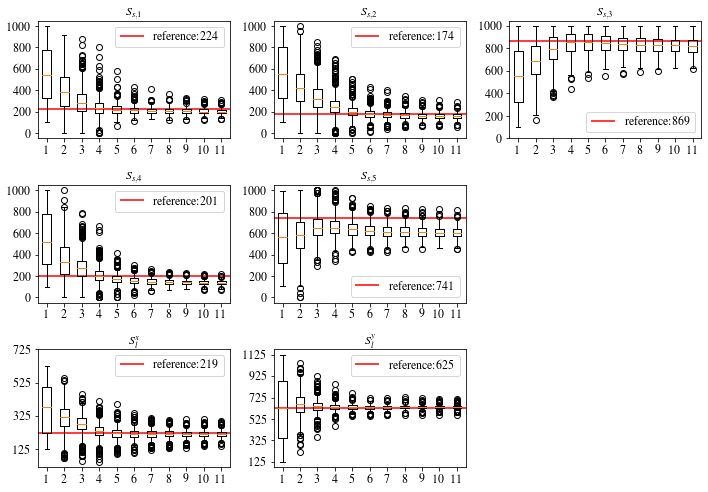

In [ ]:
## plot the source parameter ensembles
Num_ens = 960
# # Num_ens = 480
with open("/content/drive/MyDrive/react_inverse/ESMDA/ESMDA-kd_source-"+str(Num_ens)+".pkl","rb") as f:
    s = pkl.load(f)
print(Num_ens) 
fig, axs = plt.subplots(3,3,figsize=(10,7))
axs = axs.flat
 
for i in range(5):
    axs[i].boxplot(s[:,924+i,:])
    axs[i].set_title(r'$S_{s,'+str(i+1)+'}$')
    axs[i].hlines(real_source_rate[i],0.5,s[:,924+i,:].shape[1]+0.5,'r',
                  label='reference:'+str(round(real_source_rate[i]))
                  )
    axs[i].set_yticks([int(_) for _ in np.arange(0, 1001, step=200)])
    axs[i].legend()

dx, dy = 2500/80, 1250/40
axs[7].boxplot(s[:,929,:]*dx)
axs[7].set_title(r'$S^y_l$')
axs[7].hlines(real_source_loc[1]*dx,0.5, s[:,924+i,:].shape[1]+0.5,'r',
              label='reference:'+str(round(real_source_loc[1]*dx))
              )
axs[7].legend()
axs[7].set_yticks([125,325,525,725,925,1125])

axs[6].boxplot(s[:,930,:]*dy)
axs[6].set_title(r'$S^x_l$')
axs[6].hlines(real_source_loc[2]*dy,0.5, s[:,924+i,:].shape[1]+0.5,'r',
              label='reference:'+str(round(real_source_loc[2]*dy))
              )
axs[6].legend()
axs[6].set_yticks([125,325,525,725])

fig.delaxes(axs[5])
fig.delaxes(axs[8])

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/react_inverse/ESMDA/boxplot-'+str(Num_ens)+'.pdf')

## CAAE-ESMDA inspection, experiment performed with PC, not with GoogleColab

In [ ]:
## read the parameters ensembles from saved files, obtained with CAAE-ESMDA on PC
s = []  
obs = []
i = 0
while 's_{}.pkl'.format(i+1) in os.listdir('/content/drive/MyDrive/react_inverse/MT3D-ESMDA/'):
    with open('/content/drive/MyDrive/react_inverse/MT3D-ESMDA/s_{}.pkl'.format(i+1),'rb') as file:
        [s_, sim_obs] = pkl.load(file)
    s.append(s_)
    obs.append(sim_obs)
    i += 1
s = np.stack(s)
obs = np.stack(obs)
s = np.transpose(s, axes=(1,2,0))
print('shape of s',s.shape)#should be (N_ens, nd, Na)
Num_ens = s.shape[0]

shape of s (960, 931, 11)


In [ ]:
Num_ens = 960
with open("/content/drive/MyDrive/react_inverse/MT3D-ESMDA/ESMDA-kd_source-"+str(Num_ens)+".pkl","wb") as f:
    pkl.dump(s, f)


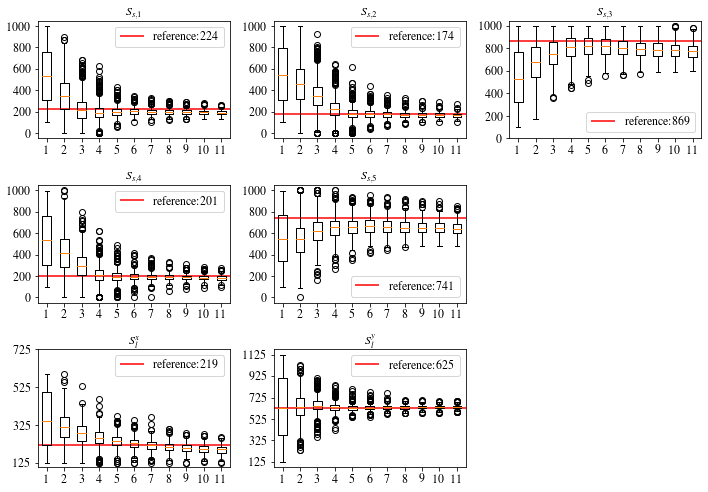

In [ ]:
with open("/content/drive/MyDrive/react_inverse/MT3D-ESMDA/ESMDA-kd_source-"+str(Num_ens)+".pkl","rb") as f:
    s = pkl.load(f)
fig, axs = plt.subplots(3,3,figsize=(10,7))
axs = axs.flat
 
for i in range(5):
    axs[i].boxplot(s[:,924+i,:])
    axs[i].set_title(r'$S_{s,'+str(i+1)+'}$')
    axs[i].hlines(real_source_rate[i],0.5,s[:,924+i,:].shape[1]+0.5,'r',
                  label='reference:'+str(round(real_source_rate[i]))
                  )
    axs[i].set_yticks([int(_) for _ in np.arange(0, 1001, step=200)])
    axs[i].legend()

dx, dy = 2500/80, 1250/40

axs[7].boxplot(s[:,929,:]*dx)
axs[7].set_title(r'$S^y_l$')
axs[7].hlines(real_source_loc[1]*dx,0.5, s[:,924+i,:].shape[1]+0.5,'r',
              label='reference:'+str(round(real_source_loc[1]*dx))
              )
axs[7].legend()
axs[7].set_yticks([125,325,525,725,925,1125])

axs[6].boxplot(s[:,930,:]*dy)
axs[6].set_title(r'$S^x_l$')
axs[6].hlines(real_source_loc[2]*dy,0.5, s[:,924+i,:].shape[1]+0.5,'r',
              label='reference:'+str(round(real_source_loc[2]*dy))
              )
axs[6].legend()
axs[6].set_yticks([125,325,525,725])

fig.delaxes(axs[5])
fig.delaxes(axs[8])

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/react_inverse/MT3D-ESMDA/boxplot-'+str(Num_ens)+'.pdf')

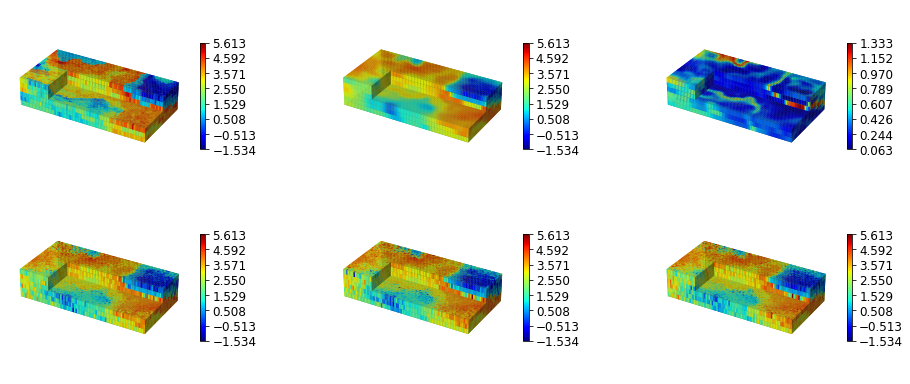

In [ ]:
## plot the true kd, mean kd, std kd, and three samples generated with mean and std.

Num_ens = s.shape[0]
all_logk = np.zeros((Num_ens, 6, 41, 81))
n_k = 24
for j in range(Num_ens//n_k):
    all_logk[j*n_k:(j+1)*n_k,:] = to_numpy(
        decoder(
            Tensor(s[j*n_k:(j+1)*n_k,:924,-1]).reshape((-1, nf, d, h, w))
        ).reshape(-1, 6, 41, 81)
    )
    torch.cuda.empty_cache()
mean_logk = np.mean(all_logk, axis=0)
std_logk = np.std(all_logk, axis=0)
# print(std_latent)
np.random.seed(888)
kd_samp = []
for i in range(3):
    kd_samp.append(np.random.normal(mean_logk, std_logk))

title = 'esmda_kd_source-'+str(Num_ens)
cut=[3, 20+1, 20-1]
fig = plt.figure(figsize=(15, 5.5))
data_all = [to_numpy(real_hk), mean_logk]
vmin = np.min(np.array(data_all))
vmax = np.max(np.array(data_all))

v1 = np.linspace(vmin,vmax, 8, endpoint=True)
i = 1
# titles = ['real', 'generated']
## plot real and mean of samples
for ind, data in enumerate(data_all):
    data = np.transpose(data, (2, 1, 0))
    data = np.flip(data, axis=2)
    filled = np.ones(data.shape)
    if cut is not None:
        filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
    x, y, z = np.indices(np.array(filled.shape) + 1)
    
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    ax = fig.add_subplot(2, 3, i, projection='3d')
    ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm(data)), edgecolors=None)
    ax.set_box_aspect([250, 125, 50])
    # ax.set_title(titles[ind])
    m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    m.set_array([])
    ax.set_axis_off()
    i += 1
    fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04, ticks=v1,)
## plot std
data = std_logk
data = np.transpose(data, (2, 1, 0))
data = np.flip(data, axis=2)
vmin_std = np.min(np.array(data))
vmax_std = np.max(np.array(data))
filled = np.ones(data.shape)
if cut is not None:
    filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
x, y, z = np.indices(np.array(filled.shape) + 1)
norm_std = matplotlib.colors.Normalize(vmin=vmin_std, vmax=vmax_std)
ax = fig.add_subplot(2, 3, i, projection='3d')
ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm_std(data)), edgecolors=None)
ax.set_box_aspect([250, 125, 50])
# ax.set_title(titles[ind])
m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm_std)
m.set_array([])
ax.set_axis_off()
i += 1   
v1_std = np.linspace(vmin_std,vmax_std, 8, endpoint=True)
fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04, ticks=v1_std,)

## plot posterior samples
data_all = [kd_samp[0], kd_samp[1], kd_samp[2]]
for ind, data in enumerate(data_all):
    data = np.transpose(data, (2, 1, 0))
    data = np.flip(data, axis=2)
    filled = np.ones(data.shape)
    if cut is not None:
        filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
    x, y, z = np.indices(np.array(filled.shape) + 1)
    
    ax = fig.add_subplot(2, 3, i, projection='3d')
    ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm(data)), edgecolors=None)
    ax.set_box_aspect([250, 125, 50])
    # ax.set_title(titles[ind])
    m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    m.set_array([])
    ax.set_axis_off()
    i += 1
    fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04, ticks=v1,)

plt.tight_layout()
# ax.set_title(title)
plt.savefig('/content/drive/MyDrive/react_inverse/MT3D-ESMDA/'+title+'.pdf',bbox_inches='tight')
##takes 3 min 50 second

In [14]:
## compute release strength error of CAAE-DenseED-ESMDA
Num_ens = 960
with open("/content/drive/MyDrive/react_inverse/ESMDA/ESMDA-kd_source-"+str(Num_ens)+".pkl","rb") as f:
    s_surro = pkl.load(f)

mean_ratio = (np.mean(s_surro[:,924:929,-1], axis=0)-real_source_rate)/real_source_rate*100
print(mean_ratio)

[ -9.63577407  -8.00251007  -5.17231797 -32.05239582 -18.26821458]


In [7]:
## compute release strength error of CAAE-ESMDA
Num_ens = 960
with open("/content/drive/MyDrive/react_inverse/MT3D-ESMDA/ESMDA-kd_source-"+str(Num_ens)+".pkl","rb") as f:
    s = pkl.load(f)

mean_ratio = (np.mean(s[:,924:929,-1], axis=0)-real_source_rate)/real_source_rate*100
print(mean_ratio)

[-14.34508729  -3.56150457 -10.77424383  -8.72846078 -13.07857006]


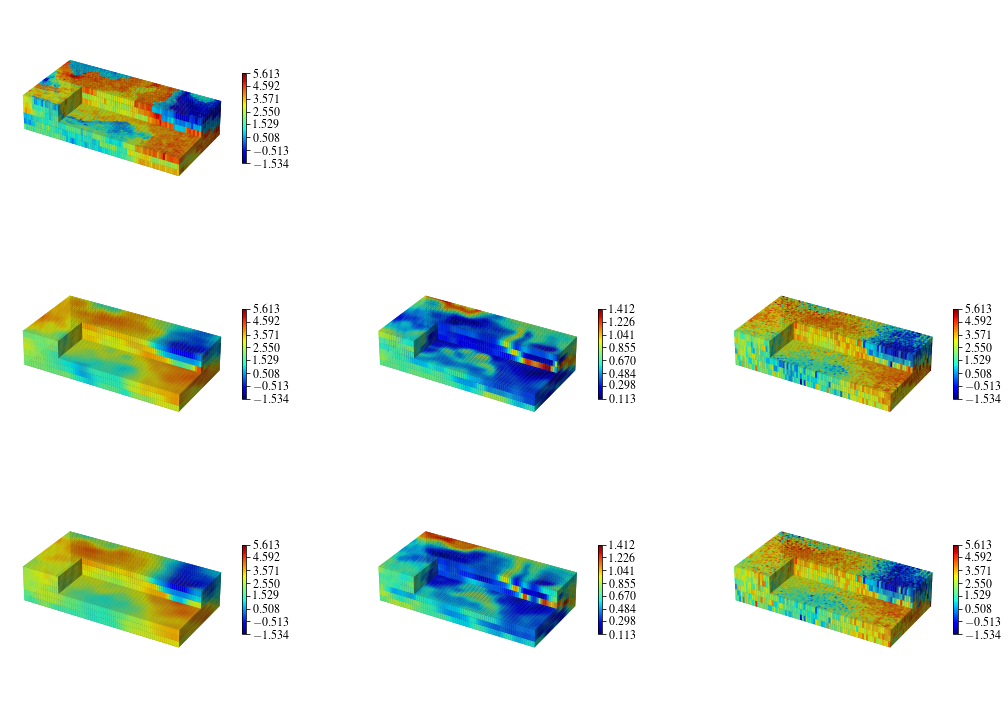

In [ ]:
##plot the comparison of the kd inversion results of CAAE-ESMDA and CAAE-DenseED-ESMDA
with open("/content/drive/MyDrive/react_inverse/MT3D-ESMDA/ESMDA-kd_source-"+str(Num_ens)+".pkl","rb") as f:
    s = pkl.load(f)

all_logk = np.zeros((Num_ens, 6, 41, 81))
n_k = 24
for j in range(Num_ens//n_k):
    all_logk[j*n_k:(j+1)*n_k,:] = to_numpy(
        decoder(
            Tensor(s[j*n_k:(j+1)*n_k,:924,-1]).reshape((-1, nf, d, h, w))
        ).reshape(-1, 6, 41, 81)
    )
    torch.cuda.empty_cache()
mean_logk = np.mean(all_logk, axis=0)
std_logk = np.std(all_logk, axis=0)
# print(std_latent)
np.random.seed(888)
kd_samp = []
for i in range(1):
    kd_samp.append(np.random.normal(mean_logk, std_logk))

with open("/content/drive/MyDrive/react_inverse/ESMDA/fixed_ESMDA-kd_source-"+str(Num_ens)+".pkl","rb") as f:
    s_surro = pkl.load(f)

all_logk = np.zeros((Num_ens, 6, 41, 81))
n_k = 24
for j in range(Num_ens//n_k):
    all_logk[j*n_k:(j+1)*n_k,:] = to_numpy(
        decoder(
            Tensor(s_surro[j*n_k:(j+1)*n_k,:924,-1]).reshape((-1, nf, d, h, w))
        ).reshape(-1, 6, 41, 81)
    )
    torch.cuda.empty_cache()
mean_logk_surro = np.mean(all_logk, axis=0)
std_logk_surro = np.std(all_logk, axis=0)
# print(std_latent)
np.random.seed(888)
kd_samp_surro = []
for i in range(1):
    kd_samp_surro.append(np.random.normal(mean_logk_surro, std_logk_surro))


vmins = {str(i):[] for i in range(7)}
vmaxs = {str(i):[] for i in range(7)}
v1s = {str(i):[] for i in range(7)}

data_all = [to_numpy(real_hk), mean_logk, mean_logk_surro, 
            std_logk, std_logk_surro, 
            kd_samp[0],kd_samp_surro[0]]
vmin = np.min(np.array(data_all[:3]))
vmax = np.max(np.array(data_all[:3]))
v1 = np.linspace(vmin,vmax, 8, endpoint=True)
vmins['0'],vmins['1'],vmins['2'] = vmin,vmin,vmin
vmaxs['0'],vmaxs['1'],vmaxs['2'] = vmax,vmax,vmax
v1s['0'],v1s['1'],v1s['2'] = v1,v1,v1
vmins['5'],vmins['6'] = vmin,vmin
vmaxs['5'],vmaxs['6'] = vmax,vmax
v1s['5'],v1s['6'] = v1,v1

vmin = np.min(np.array(data_all[3:5]))
vmax = np.max(np.array(data_all[3:5]))
v1 = np.linspace(vmin,vmax, 8, endpoint=True)
vmins['3'],vmins['4'] = vmin,vmin
vmaxs['3'],vmaxs['4'] = vmax,vmax
v1s['3'],v1s['4'] = v1,v1

title = 'twoscenarios-'+str(Num_ens)
cut=[3, 20+1, 20-1]
fig = plt.figure(figsize=(15, 10))

locs = [1, 4, 7, 5, 8, 6, 9]
# titles = ['real', 'generated']
## plot real and mean of samples
for ind, data in enumerate(data_all):
    data = np.transpose(data, (2, 1, 0))
    data = np.flip(data, axis=2)
    filled = np.ones(data.shape)
    if cut is not None:
        filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
    x, y, z = np.indices(np.array(filled.shape) + 1)
    
    norm = matplotlib.colors.Normalize(vmin=vmins[str(ind)], vmax=vmaxs[str(ind)])
    
    ax = fig.add_subplot(3, 3, locs[ind], projection='3d')
    ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm(data)), edgecolors=None)
    ax.set_box_aspect([250, 125, 50])
    # ax.set_title(titles[ind])
    m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    m.set_array([])
    ax.set_axis_off()
    i += 1
    fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04, ticks=v1s[str(ind)],)

plt.tight_layout()
# ax.set_title(title)
plt.savefig('/content/drive/MyDrive/react_inverse/ESMDA/'+title+'.pdf',bbox_inches='tight')


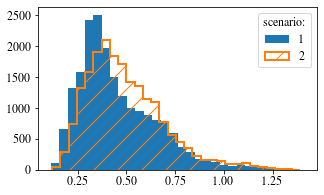

In [ ]:
## plot the histogram of the standard deviations, scenario 1: CAAE-ESMDA, 2: CAAE-DenseED-ESMDA
fig,ax = plt.subplots(1,1,figsize=(5,3))

ax.hist(std_logk.reshape(-1),bins=30,label= '1')
ax.hist(std_logk_surro.reshape(-1),bins=30, histtype='step', linewidth=2, 
         hatch='/',label='2')
ax.legend(title='scenario:')
fig.savefig('/content/drive/MyDrive/react_inverse/ESMDA/hist_std.pdf')